In [1]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 5
time_steps = 101
category = 2
max_data_size = 100000
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


Using TensorFlow backend.


In [2]:
def reverse_complement(sequence):
    retseq = ''
    for k in range(len(sequence)-1, -1, -1):
        if sequence[k] == 'A':
            retseq = retseq + 'T'
        elif sequence[k] == 'T':
            retseq = retseq + 'A'
        elif sequence[k] == 'C':
            retseq = retseq + 'G'
        elif sequence[k] == 'G':
            retseq = retseq + 'C'
        else:
            retseq = retseq + sequence[k]

    """
    print("Revese:")
    print(sequence)
    print(retseq)
    print()
    """
    return retseq


In [3]:
file_read = open("../imgtvgene_sequence_classification/naive.txt")

source_sequence = []
target_sequence = []

cluster_tag = []
cluster_dic = {}
classes = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0
max_count = 1000000

max_source = 0
max_target = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    if not split[1] in cluster_dic:
        classes += 1
        cluster_dic[split[1]] = classes
    cluster_tag.append(split[1])
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source < len(source):
        max_source = len(source)
    
    target = [char_to_int[x] for x in split[-2][1:-1]]
    target_sequence.append(target)
    if max_target < len(target):
        max_target = len(target)
    
    vgene_name = split[-1][1:-1].split("-")[0]
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
source_sequence = np.array(source_sequence)
target_sequence = np.array(target_sequence)

cluster_tag = np.array(cluster_tag)
vgene_tag = np.array(vgene_tag)

print(source_sequence.shape, target_sequence.shape)
print(max_source, max_target)
print()
print(cluster_tag.shape, vgene_tag.shape)
print(classes, vgenes)


(1000000,) (1000000,)
526 207

(1000000,) (1000000,)
203966 7


In [4]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

x_data = pad_sequences(source_sequence, maxlen=max_source, value=0)
y_data = to_categorical(vgene_tag)

train_index = int((len(x_data) / batch_size) * 0.60 * batch_size)
eval_index = train_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
test_index = eval_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
print("train, eval, test = ", (train_index, eval_index, test_index))

x_train = x_data[0:train_index]
y_train = y_data[0:train_index]

x_eval = x_data[train_index:eval_index]
y_eval = y_data[train_index:eval_index]

x_test = x_data[eval_index:test_index]
y_test = y_data[eval_index:test_index]

print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)
print(x_test.shape, y_test.shape)

train, eval, test =  (600000, 800000, 1000000)
(600000, 526) (600000, 7)
(200000, 526) (200000, 7)
(200000, 526) (200000, 7)


In [5]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

input_source = Input(shape=(max_source,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=max_source, \
                      name='embedding')(input_source)

reshape_layer = Reshape((max_source*embedding_size,))(embedding)
dense_layer_first = Dense(1024, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(128, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(64, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(vgenes, activation='softmax', \
                     name='output')(dense_layer)

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 526)               0         
_________________________________________________________________
embedding (Embedding)        (None, 526, 5)            30        
_________________________________________________________________
reshape_1 (Reshape)          (None, 2630)              0         
_________________________________________________________________
fstlayer (Dense)             (None, 1024)              2694144   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
midlayer (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [6]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(x_train, y_train, \
          validation_data=(x_eval, y_eval), \
          epochs=20, shuffle=True, batch_size=1000, \
           callbacks=[TQDMNotebookCallback()], verbose=2)
score = model.evaluate(x_test, y_test, \
                       batch_size=1000, verbose=2)
print(score)

Train...
Train on 600000 samples, validate on 200000 samples
Epoch 1/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 90s - loss: 0.1092 - acc: 0.9622 - val_loss: 0.0080 - val_acc: 0.9974
Epoch 2/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 89s - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0048 - val_acc: 0.9987
Epoch 3/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 88s - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0080 - val_acc: 0.9979
Epoch 4/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 88s - loss: 8.7597e-04 - acc: 0.9998 - val_loss: 0.0037 - val_acc: 0.9993
Epoch 5/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 88s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0048 - val_acc: 0.9991
Epoch 6/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 88s - loss: 5.1560e-04 - acc: 0.9999 - val_loss: 0.0045 - val_acc: 0.9992
Epoch 7/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 87s - loss: 6.4421e-04 - acc: 0.9998 - val_loss: 0.0040 - val_acc: 0.9993
Epoch 8/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 88s - loss: 6.2912e-04 - acc: 0.9999 - val_loss: 0.0036 - val_acc: 0.9993
Epoch 9/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 87s - loss: 5.1840e-04 - acc: 0.9999 - val_loss: 0.0033 - val_acc: 0.9994
Epoch 10/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 89s - loss: 7.7511e-04 - acc: 0.9998 - val_loss: 0.0039 - val_acc: 0.9993
Epoch 11/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 118s - loss: 4.8900e-04 - acc: 0.9999 - val_loss: 0.0042 - val_acc: 0.9993
Epoch 12/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 88s - loss: 4.8767e-04 - acc: 0.9999 - val_loss: 0.0031 - val_acc: 0.9994
Epoch 13/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 86s - loss: 4.3308e-04 - acc: 0.9999 - val_loss: 0.0033 - val_acc: 0.9994
Epoch 14/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 86s - loss: 2.5362e-04 - acc: 0.9999 - val_loss: 0.0039 - val_acc: 0.9995
Epoch 15/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 86s - loss: 4.5780e-04 - acc: 0.9999 - val_loss: 0.0043 - val_acc: 0.9993
Epoch 16/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 86s - loss: 3.0585e-04 - acc: 0.9999 - val_loss: 0.0046 - val_acc: 0.9994
Epoch 17/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 85s - loss: 3.8354e-04 - acc: 0.9999 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 18/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 85s - loss: 4.8352e-04 - acc: 0.9999 - val_loss: 0.0046 - val_acc: 0.9993
Epoch 19/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 86s - loss: 4.6374e-04 - acc: 0.9999 - val_loss: 0.0057 - val_acc: 0.9993
Epoch 20/20


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 - 87s - loss: 3.4896e-04 - acc: 0.9999 - val_loss: 0.0050 - val_acc: 0.9993

[0.002965796444089932, 0.9995600038766861]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


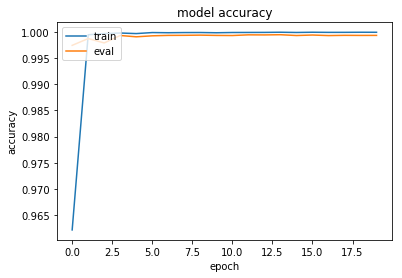

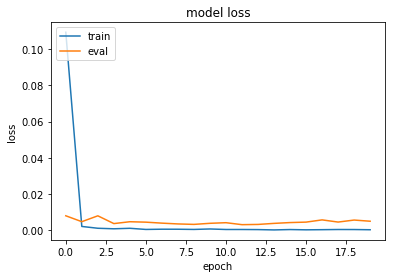

In [7]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

In [8]:
layer_name = "finlayer"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).get_output_at(0))
intermediate_output = intermediate_layer_model.predict(x_test)


In [ ]:
from sklearn.manifold import TSNE
st_index = int(len(intermediate_output) / 2) - 5000
end_index = st_index + 10000
twod_embeddings = TSNE(n_components=2).fit_transform(intermediate_output[:])
print(twod_embeddings.shape)